In [122]:
import pandas as pd
import matplotlib.pyplot as plt

loads pv_nominal_output WT_nominal_output            \
                                                               1         2   
Scenario Time_step                                                           
0        1          0.379980               0.0           0.06850  0.173250   
         2          0.423130               0.0           0.07084  0.178580   
         3          0.535564               0.0           0.07957  0.198465   
         4          0.862801               0.0           0.07768  0.194160   
         5          0.255387               0.0           0.08479  0.210355   
...                      ...               ...               ...       ...   
4        8756       2.685047               0.0           0.38190  0.561150   
         8757       1.751657               0.0           0.23540  0.383785   
         8758       1.887731               0.0           0.15140  0.297685   
         8759       1.596432               0.0           0.10080  0.245820   
         8760       0.535990               0.0           0.07345  0.184525   

                            rectifier_energy_output inverter_energy_output  \
                          3                                                  
Scenario Time_step                                                           
0        1          1.05250                     0.0               0.379980   
         2          1.07460                     0.0               0.423130   
         3          1.15705                     0.0               0.535564   
         4          1.13920                     0.0               0.737107   
         5          1.20635                     0.0               0.000000   
...                     ...                     ...                    ...   
4        8756       3.24460                     0.0               0.728535   
         8757       2.33165                     0.0               0.000000   
         8758       1.72265                     0.0               0.000000   
         8759       1.35580                     0.0               0.000000   
         8760       1.09925                     0.0               0.000000   

                    NSL PV_energy_gen_output WT_energy_gen_output            \
                                                                1    2    3   
Scenario Time_step                                                            
0        1          0.0                  0.0                  0.0  0.0  0.0   
         2          0.0                  0.0                  0.0  0.0  0.0   
         3          0.0                  0.0                  0.0  0.0  0.0   
         4          0.0                  0.0                  0.0  0.0  0.0   
         5          0.0                  0.0                  0.0  0.0  0.0   
...                 ...                  ...                  ...  ...  ...   
4        8756       0.0                  0.0                  0.0  0.0  0.0   
         8757       0.0                  0.0                  0.0  0.0  0.0   
         8758       0.0                  0.0                  0.0  0.0  0.0   
         8759       0.0                  0.0                  0.0  0.0  0.0   
         8760       0.0                  0.0                  0.0  0.0  0.0   

                   stg_flowIn      stg_flowOut           stg_SoC            \
                            1    2           1         2       1         2   
Scenario Time_step                                                           
0        1                0.0  0.0         0.0  0.399979     0.0  2.090808   
         2                0.0  0.0         0.0  0.445400     0.0  1.631549   
         3                0.0  0.0         0.0  0.563751     0.0  1.050297   
         4                0.0  0.0         0.0  0.775902     0.0  0.250356   
         5                0.0  0.0         0.0  0.000000     0.0  0.250346   
...                       ...  ...         ...       ...     ...       ...   
4        8756             0.

In [127]:
filename = "results_sensiFuel.h5"
df_results = pd.read_hdf(filename, key='df_results')
dfTS = pd.read_hdf(filename, key='df_resultsTS')

dfTS['Time_step'] = dfTS.index.astype(int)
df_resultsTS = dfTS.set_index(['Scenario', 'Time_step'])

for s in df_results.index:
    # lcoe
    energy_supplied = (df_resultsTS.loc[s]['loads']-df_resultsTS.loc[s]['NSL']).sum()
    df_results.at[s, 'lcoe'] = float(df_results.loc[s]['total_cost']/energy_supplied)
    
    # RE share
    df_results.at[s,'GEN_annual_output_kWh'] = df_resultsTS.loc[s]['GEN_energy_gen_output'].sum()
    df_results.at[s,'PV_annual_output_kWh'] = df_resultsTS.loc[s]['PV_energy_gen_output'].sum()
    df_results.at[s,'WT_annual_output_kWh'] = df_resultsTS.loc[s]['WT_energy_gen_output'].sum().sum()
    df_results.at[s,'RE_share'] = (1 - (df_results.GEN_annual_output_kWh[s]/(df_results.GEN_annual_output_kWh[s]+df_results.PV_annual_output_kWh[s]+df_results.WT_annual_output_kWh[s]))).round(4)*100
    df_results.at[s,'SOC_std'] = (df_resultsTS.loc[s]['stg_SoC'][2]/df_results.loc[s]['stg_capacity'][2]).std()
        
df_results.RE_share

0    37.60
1    26.29
2    31.42
3    45.79
4    55.75
Name: RE_share, dtype: float64

In [128]:
df_results_single_col = df_results.sum(level=0, axis=1)
df_comp = pd.DataFrame()
df_caps = df_results_single_col[['PV_capacity','stg_capacity','GEN_capacity']]
df_caps.columns = ['PV capacity [kW]', 'Battery capacity [kWh]', 'Diesel Generator capacity [kW]']
df_caps = df_caps.reindex([1,2,0,3, 4])
df_caps = df_caps.rename(index={1: -30, 2: -15, 0: 'Base', 3: +15, 4: +30})

df_lcoe = df_results_single_col[['lcoe']]
df_lcoe.columns = ['Levelized cost of electricity']
df_lcoe = df_lcoe.reindex([1,2,0,3, 4])
df_lcoe = df_lcoe.rename(index={1: -30, 2: -15, 0: 'Base', 3: +15, 4: +30})

df_comp = df_results_single_col[['lcoe','RE_share','SOC_std','PV_capacity','stg_capacity','GEN_capacity']]
df_comp = df_comp.reindex([1,2,0,3, 4])
df_comp = df_comp.rename(index={1: -30, 2: -15, 0: 'Base', 3: +15, 4: +30})
df_comp.to_csv('Fuelsensi.csv')
df_comp

,lcoe,RE_share,SOC_std,PV_capacity,stg_capacity,GEN_capacity
-30,0.237234,26.29,0.250133,1.700977,1.381490,3.836436
-15,0.266162,31.42,0.257265,2.154112,1.693190,3.577940
Base,0.293558,37.60,0.264994,2.654344,2.503258,3.242048
15,0.317940,45.79,0.280709,3.282998,4.013587,2.615795
30,0.338987,55.75,0.296332,4.016855,6.378885,1.956511


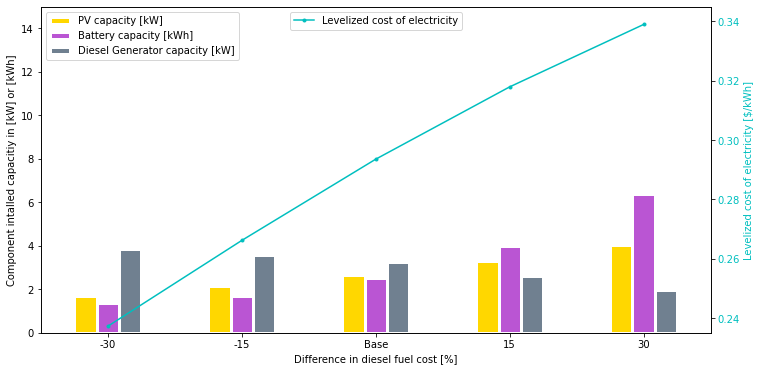

In [129]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 6]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlim(-1, len(df_caps))
ax1.set_xlabel('Difference in diesel fuel cost [%]')
ax1.set_ylabel('Component intalled capacitiy in [kW] or [kWh]')
df_caps.plot(ax = ax1, kind="bar", rot= 0, color=['gold','mediumorchid', 'slategray'], edgecolor='white', linewidth=3)
ax1.legend(loc=2)
ax1.set_ylim(0,15)

color = 'c'
ax2.set_ylabel('Levelized cost of electricity [$/kWh]', color=color)  # we already handled the x-label with ax1
df_lcoe.plot(ax = ax2, style='.-', color = color)
ax2.legend(loc=9)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(-0.5, len(df_caps)-0.5)
ax2.set_ylim(0.235,0.345)

plt.savefig('fuelSensi.png',bbox_inches='tight')
plt.show()


In [130]:
filename = "results_sensiPV.h5"
df_results = pd.read_hdf(filename, key='df_results')
dfTS = pd.read_hdf(filename, key='df_resultsTS')

dfTS['Time_step'] = dfTS.index.astype(int)
df_resultsTS = dfTS.set_index(['Scenario', 'Time_step'])

for s in df_results.index:
    # lcoe
    energy_supplied = (df_resultsTS.loc[s]['loads']-df_resultsTS.loc[s]['NSL']).sum()
    df_results.at[s, 'lcoe'] = float(df_results.loc[s]['total_cost']/energy_supplied)
    
    # RE share
    df_results.at[s,'GEN_annual_output_kWh'] = df_resultsTS.loc[s]['GEN_energy_gen_output'].sum()
    df_results.at[s,'PV_annual_output_kWh'] = df_resultsTS.loc[s]['PV_energy_gen_output'].sum()
    df_results.at[s,'WT_annual_output_kWh'] = df_resultsTS.loc[s]['WT_energy_gen_output'].sum().sum()
    df_results.at[s,'RE_share'] = (1 - (df_results.GEN_annual_output_kWh[s]/(df_results.GEN_annual_output_kWh[s]+df_results.PV_annual_output_kWh[s]+df_results.WT_annual_output_kWh[s]))).round(4)*100
    df_results.at[s,'SOC_std'] = (df_resultsTS.loc[s]['stg_SoC'][2]/df_results.loc[s]['stg_capacity'][2]).std()

In [131]:
df_results_single_col = df_results.sum(level=0, axis=1)
df_comp = pd.DataFrame()
df_caps = df_results_single_col[['PV_capacity','stg_capacity','GEN_capacity']]
df_caps.columns = ['PV capacity [kW]', 'Battery capacity [kWh]', 'Diesel Generator capacity [kW]']
df_caps = df_caps.reindex([1,2,3,0, 4])
df_caps = df_caps.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})

df_lcoe = df_results_single_col[['lcoe']]
df_lcoe.columns = ['Levelized cost of electricity']
df_lcoe = df_lcoe.reindex([1,2,3,0, 4])
df_lcoe = df_lcoe.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})

df_comp = df_results_single_col[['lcoe','RE_share','SOC_std','PV_capacity','stg_capacity','GEN_capacity']]
df_comp = df_comp.reindex([1,2,3,0, 4])
df_comp = df_comp.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})
df_comp.to_csv('PVsensi.csv')
df_comp

,lcoe,RE_share,SOC_std,PV_capacity,stg_capacity,GEN_capacity
-60,0.259128,54.43,0.297910,4.545366,5.274005,2.259416
-40,0.272585,47.66,0.285685,3.668189,4.041097,2.604389
-20,0.283978,42.54,0.274297,3.111287,3.226969,2.941963
Base,0.293558,37.60,0.264994,2.654344,2.503258,3.242048
20,0.301648,31.56,0.257249,2.155393,1.733850,3.561080


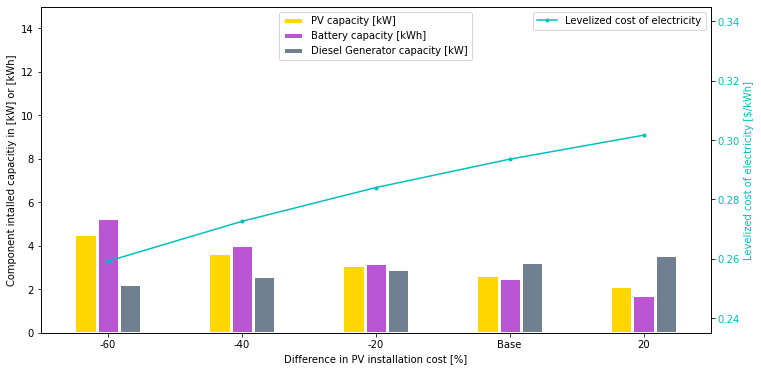

In [132]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlim(-1, len(df_caps))
ax1.set_xlabel('Difference in PV installation cost [%]')
ax1.set_ylabel('Component intalled capacitiy in [kW] or [kWh]')
df_caps.plot(ax = ax1, kind="bar", rot= 0, color=['gold','mediumorchid', 'slategray'], edgecolor='white', linewidth=3)
ax1.legend(loc=9)
ax1.set_ylim(0,15)

color = 'c'
ax2.set_ylabel('Levelized cost of electricity [$/kWh]', color=color)  # we already handled the x-label with ax1
df_lcoe.plot(ax = ax2, style='.-', color = color)
ax2.legend(loc=0)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(-0.5, len(df_caps)-0.5)
ax2.set_ylim(0.235,0.345)

plt.savefig('PVsensi.png',bbox_inches='tight')
plt.show()

In [133]:
filename = "results_sensiBat.h5"
df_results = pd.read_hdf(filename, key='df_results')
dfTS = pd.read_hdf(filename, key='df_resultsTS')

dfTS['Time_step'] = dfTS.index.astype(int)
df_resultsTS = dfTS.set_index(['Scenario', 'Time_step'])

for s in df_results.index:
    # lcoe
    energy_supplied = (df_resultsTS.loc[s]['loads']-df_resultsTS.loc[s]['NSL']).sum()
    df_results.at[s, 'lcoe'] = float(df_results.loc[s]['total_cost']/energy_supplied)
    
    # RE share
    df_results.at[s,'GEN_annual_output_kWh'] = df_resultsTS.loc[s]['GEN_energy_gen_output'].sum()
    df_results.at[s,'PV_annual_output_kWh'] = df_resultsTS.loc[s]['PV_energy_gen_output'].sum()
    df_results.at[s,'WT_annual_output_kWh'] = df_resultsTS.loc[s]['WT_energy_gen_output'].sum().sum()
    df_results.at[s,'RE_share'] = (1 - (df_results.GEN_annual_output_kWh[s]/(df_results.GEN_annual_output_kWh[s]+df_results.PV_annual_output_kWh[s]+df_results.WT_annual_output_kWh[s]))).round(4)*100
    df_results.at[s,'SOC_std'] = (df_resultsTS.loc[s]['stg_SoC'][2]/df_results.loc[s]['stg_capacity'][2]).std()


In [134]:
df_results_single_col = df_results.sum(level=0, axis=1)
df_comp = pd.DataFrame()
df_caps = df_results_single_col[['PV_capacity','stg_capacity','GEN_capacity']]
df_caps.columns = ['PV capacity [kW]', 'Battery capacity [kWh]', 'Diesel Generator capacity [kW]']
df_caps = df_caps.reindex([1,2,3,0, 4])
df_caps = df_caps.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})

df_lcoe = df_results_single_col[['lcoe']]
df_lcoe.columns = ['Levelized cost of electricity']
df_lcoe = df_lcoe.reindex([1,2,3,0, 4])
df_lcoe = df_lcoe.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})

df_comp = df_results_single_col[['lcoe','RE_share','SOC_std','PV_capacity','stg_capacity','GEN_capacity']]
df_comp = df_comp.reindex([1,2,3,0, 4])
df_comp = df_comp.rename(index={1: -60, 2: -40, 3: -20, 0: 'Base', 4: +20})
df_comp.to_csv('Batsensi.csv')
df_comp

,lcoe,RE_share,SOC_std,PV_capacity,stg_capacity,GEN_capacity
-60,0.252779,79.07,0.281558,5.207485,14.953750,1.117954
-40,0.276563,64.90,0.294319,4.369437,9.650443,1.450768
-20,0.287766,44.79,0.277843,3.116239,4.022130,2.612253
Base,0.293558,37.60,0.264994,2.654344,2.503258,3.242048
20,0.297304,32.60,0.259359,2.321094,1.693190,3.577940


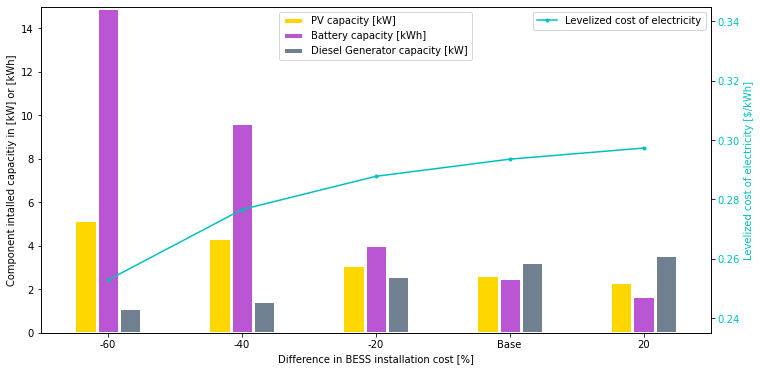

In [135]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlim(-1, len(df_caps))
ax1.set_xlabel('Difference in BESS installation cost [%]')
ax1.set_ylabel('Component intalled capacitiy in [kW] or [kWh]')
df_caps.plot(ax = ax1, kind="bar", rot= 0, color=['gold','mediumorchid', 'slategray'], edgecolor='white', linewidth=3)
ax1.legend(loc=9)
ax1.set_ylim(0,15)

color = 'c'
ax2.set_ylabel('Levelized cost of electricity [$/kWh]', color=color)  # we already handled the x-label with ax1
df_lcoe.plot(ax = ax2, style='.-', color = color)
ax2.legend(loc=0)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(-0.5, len(df_caps)-0.5)
ax2.set_ylim(0.235,0.345)

plt.savefig('Batsensi.png',bbox_inches='tight')
plt.show()

In [136]:
filename = "results_sensiNSL.h5"
df_results = pd.read_hdf(filename, key='df_results')
dfTS = pd.read_hdf(filename, key='df_resultsTS')

dfTS['Time_step'] = dfTS.index.astype(int)
df_resultsTS = dfTS.set_index(['Scenario', 'Time_step'])

for s in df_results.index:
    # lcoe
    energy_supplied = (df_resultsTS.loc[s]['loads']-df_resultsTS.loc[s]['NSL']).sum()
    df_results.at[s, 'lcoe'] = float(df_results.loc[s]['total_cost']/energy_supplied)
    
    # RE share
    df_results.at[s,'GEN_annual_output_kWh'] = df_resultsTS.loc[s]['GEN_energy_gen_output'].sum()
    df_results.at[s,'PV_annual_output_kWh'] = df_resultsTS.loc[s]['PV_energy_gen_output'].sum()
    df_results.at[s,'WT_annual_output_kWh'] = df_resultsTS.loc[s]['WT_energy_gen_output'].sum().sum()
    df_results.at[s,'RE_share'] = (1 - (df_results.GEN_annual_output_kWh[s]/(df_results.GEN_annual_output_kWh[s]+df_results.PV_annual_output_kWh[s]+df_results.WT_annual_output_kWh[s]))).round(4)*100
    df_results.at[s,'SOC_std'] = (df_resultsTS.loc[s]['stg_SoC'][2]/df_results.loc[s]['stg_capacity'][2]).std()

In [137]:
df_results_single_col = df_results.sum(level=0, axis=1)
df_comp = pd.DataFrame()
df_caps = df_results_single_col[['PV_capacity','stg_capacity','GEN_capacity']]
df_caps.columns = ['PV capacity [kW]', 'Battery capacity [kWh]', 'Diesel Generator capacity [kW]']
df_caps = df_caps.reindex([1,0,2,3, 4])
df_caps = df_caps.rename(index={1: '100 (base)', 0: 99.5, 2: 99.0, 3: 98.5, 4: 98.0})

df_lcoe = df_results_single_col[['lcoe']]
df_lcoe.columns = ['Levelized cost of electricity']
df_lcoe = df_lcoe.reindex([1,0,2,3, 4])
df_lcoe = df_lcoe.rename(index={1: '100 (base)', 0: 99.5, 2: 99.0, 3: 98.5, 4: 98.0})

df_comp = df_results_single_col[['lcoe','RE_share','SOC_std','PV_capacity','stg_capacity','GEN_capacity']]
df_comp = df_comp.reindex([1,0,2,3, 4])
df_comp = df_comp.rename(index={1: '100 (base)', 0: 99.5, 2: 99.0, 3: 98.5, 4: 98.0})
df_comp.to_csv('NSLsensi.csv')
df_comp

,lcoe,RE_share,SOC_std,PV_capacity,stg_capacity,GEN_capacity
100 (base),0.293558,37.60,0.264994,2.654344,2.503258,3.242048
99.5,0.283188,34.90,0.304200,2.460527,2.068499,2.420064
99.0,0.280826,34.27,0.317678,2.414515,1.930580,2.204768
98.5,0.279484,33.53,0.327275,2.360442,1.763977,2.080813
98.0,0.278613,33.33,0.330189,2.339777,1.713519,1.975421


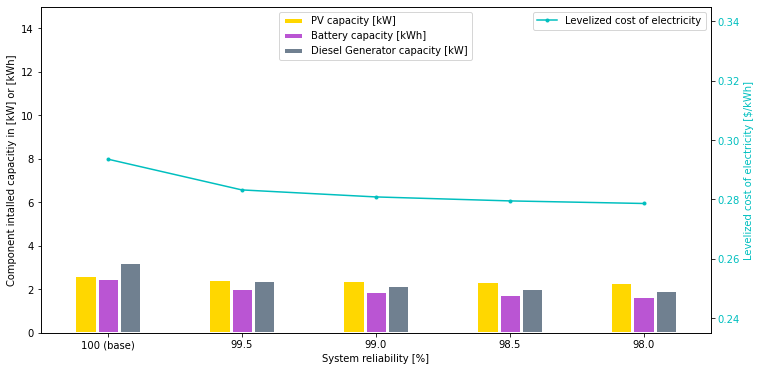

In [138]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlim(-1, len(df_caps))
ax1.set_xlabel('System reliability [%]')
ax1.set_ylabel('Component intalled capacitiy in [kW] or [kWh]')
df_caps.plot(ax = ax1, kind="bar", rot= 0, color=['gold','mediumorchid', 'slategray'], edgecolor='white', linewidth=3)
ax1.legend(loc=9)
ax1.set_ylim(0,15)

color = 'c'
ax2.set_ylabel('Levelized cost of electricity [$/kWh]', color=color)  # we already handled the x-label with ax1
df_lcoe.plot(ax = ax2, style='.-', color = color)
ax2.legend(loc=0)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(-0.5, len(df_caps)-0.5)
ax2.set_ylim(0.235,0.345)

plt.savefig('NSLsensi.png',bbox_inches='tight')
plt.show()